### User Retention for Dognition

by Assigning ranks to each completed test by chronological order for each dog/user 

Dognition is a company that provides tests for its users to assess their dogs' personality.
It is a subscription-based service, so its revenue depends on the number of tests that users complete. It is looking for ways to increase the number of tests that its users complete. 

In this notebook, I investigate if Dognition's users tend to drop out after a certain test (the tests are largely taken in a fixed order, but there are some exceptions). 

The dataset available to me contains all information on the completed tests, including the name of the completed tests, the time at which it was created (incomplete tests are not included in the dataset), and information about the dog/user. 

To find out if users tend to drop out after a certain test, I rank each completed test by each dog/user in chronological order based on the time at which the test is completed. If a Dog_ID is associated with tests with rank 1 to 4, for instance, this means that the dog/user completed tests 1-4 and the user discontinued after the 4th test. If there is a significant drop of the number of dogs/users between test 4 and 5, this means that test 5 should be improved to prevent users from dropping.  

Specifically, I clean the dataset by removing entries from test accounts, standardize the time by time-zone difference, and assign ranks to each completed tests by 2 methods (pd.groupby and using pandasql). Both methods return the same result, and I output the results to csv for Tableau dashboards. 

In addition, I investigate if free trials encourage users to complete more tests after their free trials are ended. 



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib notebook

In [3]:
x1=pd.read_excel('/Users/bling/Documents/21-22/data science/Coursera/Tableau/dognition_data_no_aggregation_with_zip_code_correction (1).xlsx',
               sheet_name=0)
x2=pd.read_excel('/Users/bling/Documents/21-22/data science/Coursera/Tableau/dognition_data_no_aggregation_with_zip_code_correction (1).xlsx',
               sheet_name=1)

In [4]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177481 entries, 0 to 177480
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Created_at        177481 non-null  datetime64[ns]
 1   Updated_at        177481 non-null  datetime64[ns]
 2   User_ID           177481 non-null  object        
 3   Dog_ID            177481 non-null  object        
 4   Test_name         177481 non-null  object        
 5   Subcategory_name  177481 non-null  object        
 6   Gender            177481 non-null  object        
 7   Birthday          177481 non-null  int64         
 8   Breed             177279 non-null  object        
 9   Breed_Type        177481 non-null  object        
 10  Breed_Group       88923 non-null   object        
 11  Weight            177481 non-null  int64         
 12  Dog_Fixed         175317 non-null  float64       
 13  DNA_Tested        52968 non-null   float64       
 14  Dime

In [5]:
# Change the datatype of Zip to int64 to prepare for merging with the time zone doc
x1.Zip=pd.to_numeric(x1.Zip, errors='coerce').fillna(0).astype('int64')

In [6]:
df_all=x1.merge(x2,how='left',on='Zip').fillna(0)

In [7]:
# Now that we have a column with hour adjustment <'Diff from UTC'>, subtract this from 'Created_at' 
# to get standardized time
from datetime import timedelta
df_all['Adj_time']=df_all.apply(lambda x: x['Created_at'] + timedelta(hours=x['Diff from UTC']) 
             if (type(x['Diff from UTC']) is not str) else x['Created_at'], axis=1)

In [8]:
df_all.head()

,Created_at,Updated_at,User_ID,Dog_ID,Test_name,Subcategory_name,Gender,Birthday,Breed,Breed_Type,...,Country,Exclude,Free_Start_User,Last_Active_At,Membership_Type,Rating,Rank_by_UserID,Rank_by_DogID,Diff from UTC,Adj_time
0,2013-05-13 16:17:00,2013-05-13 16:17:00,ce134a78-7144-11e5-ba71-058fbc01cf0b,fd3d1b44-7144-11e5-ba71-058fbc01cf0b,Yawn Warm-up,Empathy,male,2009,Shih Tzu,Pure Breed,...,US,1,0,2015-02-23 13:39:00,2,0.0,1.0,1.0,-5,2013-05-13 11:17:00
1,2013-05-22 18:54:00,2013-05-22 18:54:00,ce134a78-7144-11e5-ba71-058fbc01cf0b,fd3d1b44-7144-11e5-ba71-058fbc01cf0b,Yawn Game,Empathy,male,2009,Shih Tzu,Pure Breed,...,US,1,0,2015-02-23 13:39:00,2,0.0,2.0,2.0,-5,2013-05-22 13:54:00
2,2013-05-22 18:55:00,2013-05-22 18:55:00,ce134a78-7144-11e5-ba71-058fbc01cf0b,fd3d1b44-7144-11e5-ba71-058fbc01cf0b,Eye Contact Warm-up,Empathy,male,2009,Shih Tzu,Pure Breed,...,US,1,0,2015-02-23 13:39:00,2,0.0,3.0,3.0,-5,2013-05-22 13:55:00
3,2013-05-22 18:56:00,2013-05-22 18:56:00,ce134a78-7144-11e5-ba71-058fbc01cf0b,fd3d1b44-7144-11e5-ba71-058fbc01cf0b,Eye Contact Game,Empathy,male,2009,Shih Tzu,Pure Breed,...,US,1,0,2015-02-23 13:39:00,2,0.0,4.0,4.0,-5,2013-05-22 13:56:00
4,2013-05-22 18:58:00,2013-05-22 18:58:00,ce134a78-7144-11e5-ba71-058fbc01cf0b,fd3d1b44-7144-11e5-ba71-058fbc01cf0b,Treat Warm-up,Communication,male,2009,Shih Tzu,Pure Breed,...,US,1,0,2015-02-23 13:39:00,2,0.0,5.0,5.0,-5,2013-05-22 13:58:00


In [9]:
# For each Dog_ID, give a rank number to each test completed under that ID, based on 
# the chronological order of 'Created_at'. 
# When a Dog_ID is associated with tests with rank 1 to 4, for instance, 
# this means that the dog completed tests 1-4 and the user discontinued after the 4th test. 
# This way, we can see in what order users tend to go through the test, and by counting the
# number associated with each completed test, and if there are particular tests during which
# users tend to discontinue. 

# There are 2 ways to do this--the first one is through the rank function using groupby
df_all['rank']=df_all.groupby('Dog_ID')['Adj_time'].rank(ascending=True, method='first')

In [10]:
# Clean the data from test accounts, with 'Breed'='Shih Tzu' and 'weight'=190
df_cleaned=df_all.loc[~((df_all['Breed']=='Shih Tzu') & (df_all['Weight']==190))]
# Count the number of entries
df_cleaned.shape[0]

176281

In [11]:
# Examine the count of each rank for each time 
test_counts = df_cleaned.groupby(['Subcategory_name','Test_name','rank']).count().reset_index()
test_counts_short = test_counts[['Subcategory_name', 'Test_name','rank', 'Dog_ID']].rename(columns={'Dog_ID':'Count'})

In [12]:
test_counts_short

,Subcategory_name,Test_name,rank,Count
0,Communication,Arm Pointing,1.0,1
1,Communication,Arm Pointing,4.0,1
2,Communication,Arm Pointing,5.0,190
3,Communication,Arm Pointing,6.0,9472
4,Communication,Arm Pointing,7.0,451
...,...,...,...,...
710,Spatial Navigation,Navigation Warm-up,30.0,1
711,Spatial Navigation,Navigation Warm-up,32.0,1
712,Spatial Navigation,Navigation Warm-up,34.0,1
713,Spatial Navigation,Navigation Warm-up,36.0,2


In [13]:
# The second method is through pandasql 
!pip install pandasql

Processing /Users/bling/Library/Caches/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff/pandasql-0.7.3-py3-none-any.whl


In [14]:
from pandasql import sqldf
pysqldf = lambda q:sqldf(q, globals())

In [15]:
# Write a sql query to assign a rank to each test name each dog completed based on 
# chronological order of 'Created_at', then delete the test account data. 
query='SELECT Dog_ID, User_ID, Created_at, ROW_NUMBER() OVER(PARTITION BY Dog_ID ORDER BY Adj_time ASC) AS rank, Test_name, Subcategory_name FROM df_all WHERE NOT (Breed="Shih Tzu" AND weight=190)'
pysqldf(query)

,Dog_ID,User_ID,Created_at,rank,Test_name,Subcategory_name
0,fd27b272-7144-11e5-ba71-058fbc01cf0b,ce134e42-7144-11e5-ba71-058fbc01cf0b,2013-02-10 01:14:00.000000,1,Yawn Warm-up,Empathy
1,fd27b272-7144-11e5-ba71-058fbc01cf0b,ce134e42-7144-11e5-ba71-058fbc01cf0b,2013-02-10 01:19:00.000000,2,Yawn Game,Empathy
2,fd27b272-7144-11e5-ba71-058fbc01cf0b,ce134e42-7144-11e5-ba71-058fbc01cf0b,2013-02-10 01:22:00.000000,3,Eye Contact Warm-up,Empathy
3,fd27b272-7144-11e5-ba71-058fbc01cf0b,ce134e42-7144-11e5-ba71-058fbc01cf0b,2013-02-10 01:29:00.000000,4,Eye Contact Game,Empathy
4,fd27b272-7144-11e5-ba71-058fbc01cf0b,ce134e42-7144-11e5-ba71-058fbc01cf0b,2013-02-11 01:16:00.000000,5,Treat Warm-up,Communication
...,...,...,...,...,...,...
176276,fdc2417a-7144-11e5-ba71-058fbc01cf0b,ce9b35e6-7144-11e5-ba71-058fbc01cf0b,2015-10-12 21:17:00.000000,2,Yawn Game,Empathy
176277,fdc2417a-7144-11e5-ba71-058fbc01cf0b,ce9b35e6-7144-11e5-ba71-058fbc01cf0b,2015-10-12 21:21:00.000000,3,Eye Contact Warm-up,Empathy
176278,fdc2417a-7144-11e5-ba71-058fbc01cf0b,ce9b35e6-7144-11e5-ba71-058fbc01cf0b,2015-10-12 21:25:00.000000,4,Eye Contact Game,Empathy
176279,fdc2417a-7144-11e5-ba71-058fbc01cf0b,ce9b35e6-7144-11e5-ba71-058fbc01cf0b,2015-10-12 21:34:00.000000,5,Treat Warm-up,Communication


In [16]:
ranked_tests=pysqldf(query)
query2='SELECT COUNT(Created_at) AS Count, Test_name, Subcategory_name, rank FROM ranked_tests GROUP BY rank, Test_name, Subcategory_name ORDER BY Test_name, COUNT(Created_at)'
test_count_short_2=pysqldf(query2)

In [17]:
# The two dataframes test_count_short and test_count_short_2 produces the same results. 
test_count_short_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Count             715 non-null    int64 
 1   Test_name         715 non-null    object
 2   Subcategory_name  715 non-null    object
 3   rank              715 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.5+ KB


In [285]:
test_count_short_2.to_excel('/Users/bling/Documents/21-22/data science/Coursera/Tableau/sql_rank_agg.xlsx')

In [284]:
test_counts_short.to_excel('/Users/bling/Documents/21-22/data science/Coursera/Tableau/pd_rank_agg.xlsx')

In [279]:
# How many users complete more than 20 tests? 
query3='SELECT COUNT(DISTINCT User_ID) FROM (SELECT User_ID, MAX(rank) AS max_rank FROM ranked_tests GROUP BY User_ID) AS user_max_rank WHERE user_max_rank.max_rank>=20'
pysqldf(query3) 

,COUNT(DISTINCT User_ID)
0,3810


In [280]:
query5='SELECT COUNT(DISTINCT User_ID) FROM df_all'
pysqldf(query5)

,COUNT(DISTINCT User_ID)
0,16261


Using Tableau, I plotted the count for each test against each rank. 
As can be seen, typically users start by the "Yarm-warm up" test, goes to the "Yam Game" and so on. There is a big dig after the 4th test, so the 5th test, "Eye Contact" test, should be modified for user retention. 

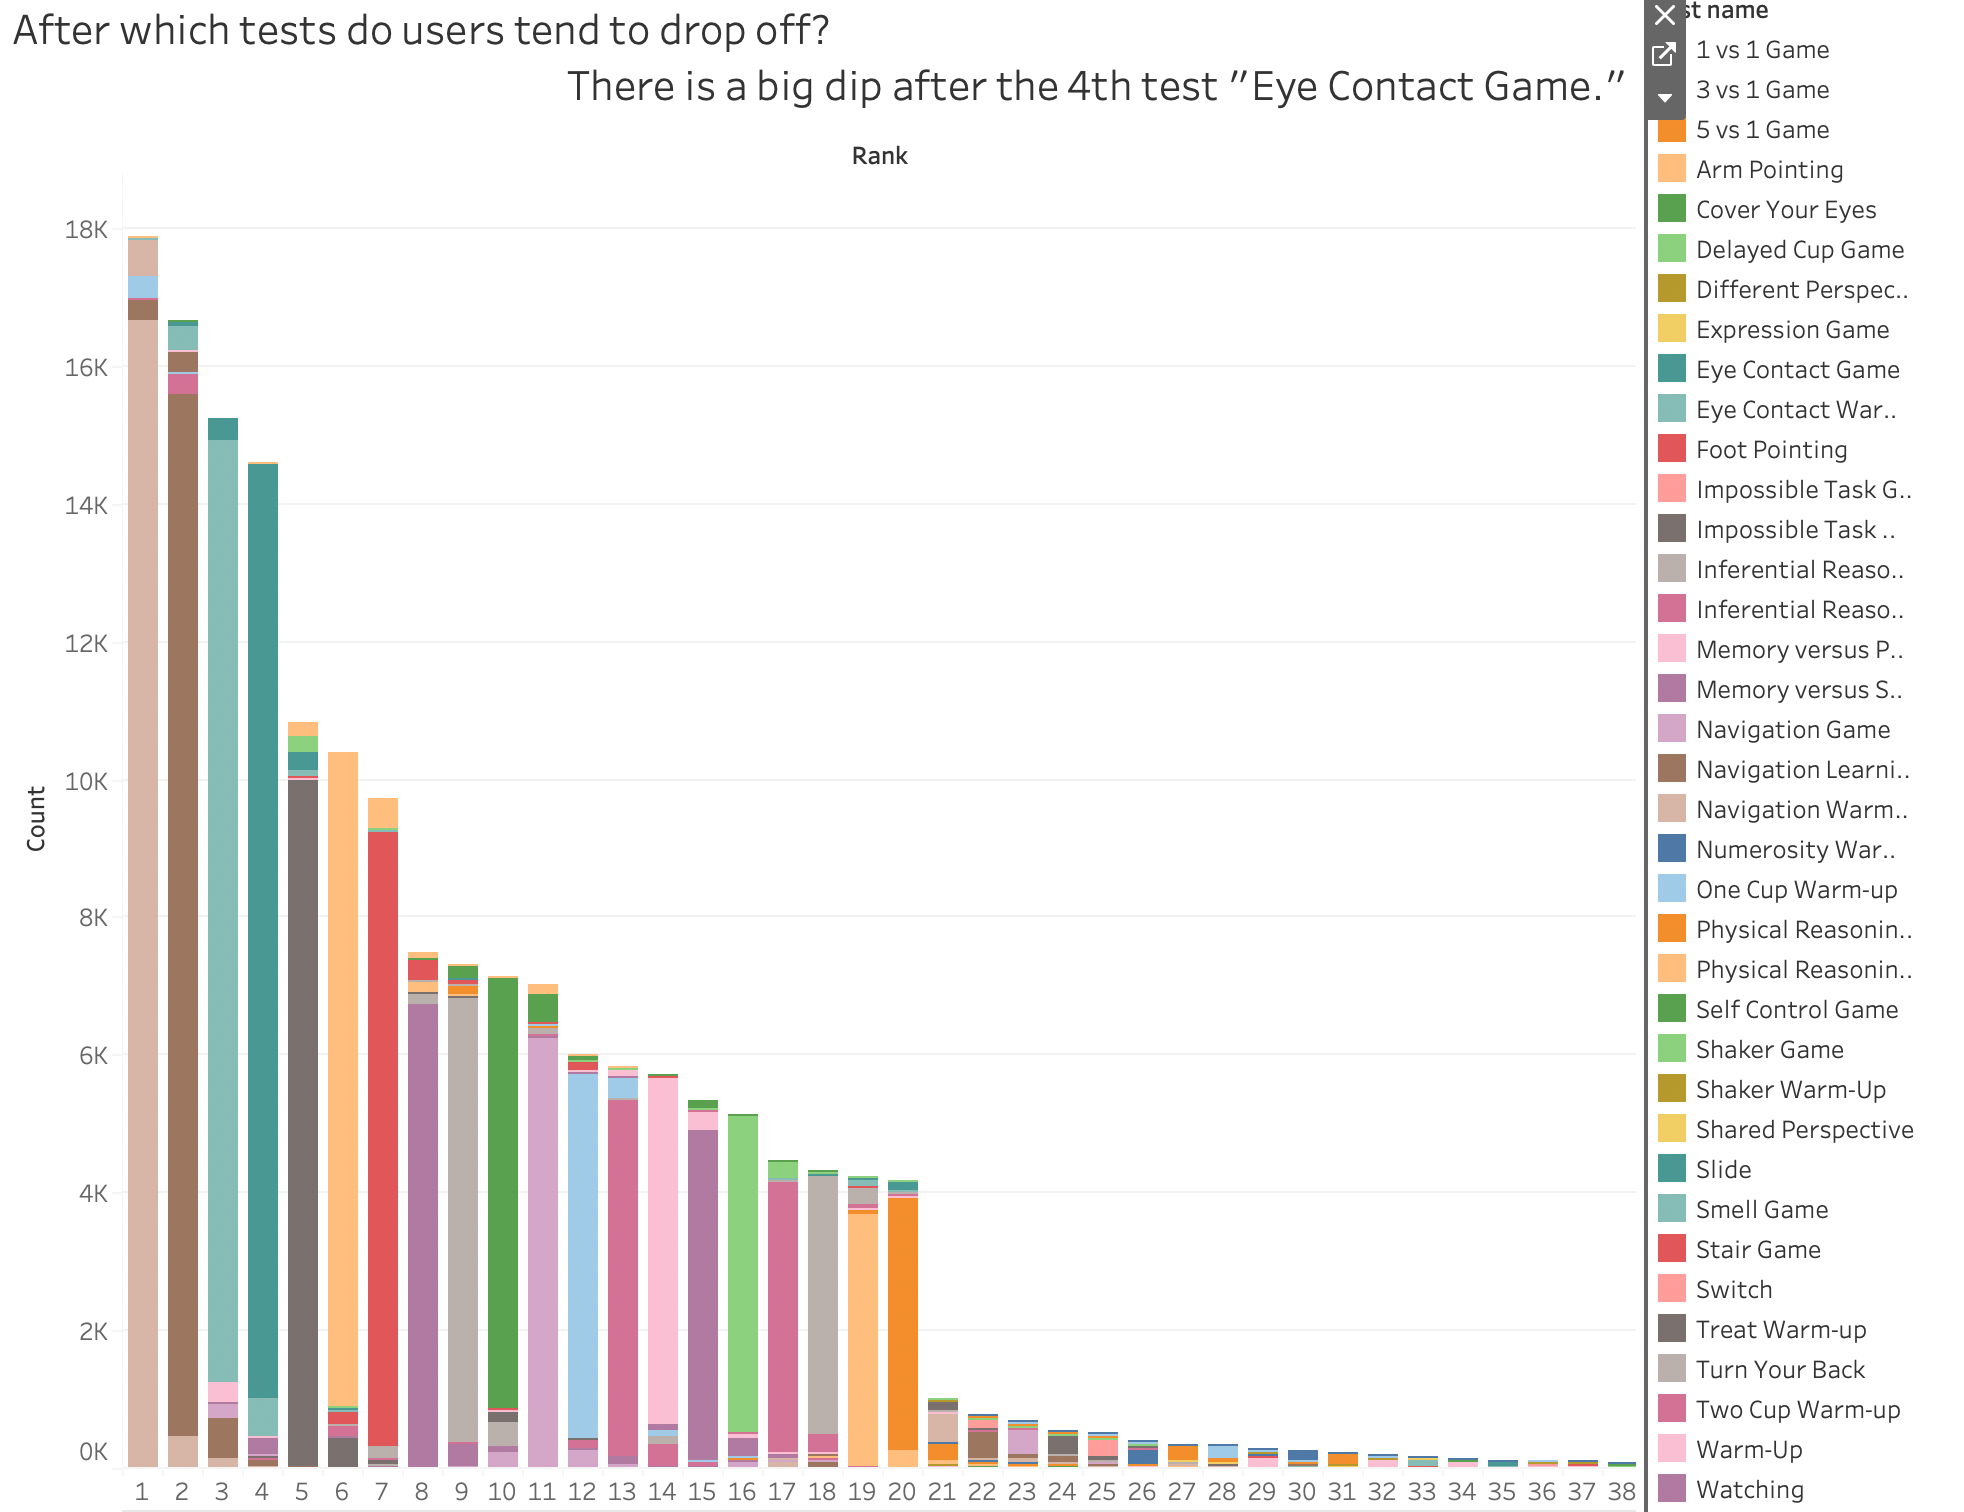

## Are free trials effective in encouraging users to do more tests? 


The next question I want to investigate is whether users from free trials (the first 4 tests) lead to long-term customers. To do so, I use the "free-start user" label to group the results. I want to look at for each of these groups, how many dogs complete 1, 2, 3,...20 tests. 

In [19]:
df_cleaned.head()

,Created_at,Updated_at,User_ID,Dog_ID,Test_name,Subcategory_name,Gender,Birthday,Breed,Breed_Type,...,Exclude,Free_Start_User,Last_Active_At,Membership_Type,Rating,Rank_by_UserID,Rank_by_DogID,Diff from UTC,Adj_time,rank
20,2013-05-17 17:45:00,2013-05-17 17:45:00,ce134be0-7144-11e5-ba71-058fbc01cf0b,fd27c956-7144-11e5-ba71-058fbc01cf0b,Yawn Warm-up,Empathy,male,2010,German Shepherd Dog-Nova Scotia Duck Tolling R...,Cross Breed,...,0,0,0,2,0.0,1.0,1.0,-5,2013-05-17 12:45:00,1.0
21,2013-05-17 17:50:00,2013-05-17 17:50:00,ce134be0-7144-11e5-ba71-058fbc01cf0b,fd27c956-7144-11e5-ba71-058fbc01cf0b,Yawn Game,Empathy,male,2010,German Shepherd Dog-Nova Scotia Duck Tolling R...,Cross Breed,...,0,0,0,2,0.0,2.0,2.0,-5,2013-05-17 12:50:00,2.0
22,2013-05-17 17:55:00,2013-05-17 17:55:00,ce134be0-7144-11e5-ba71-058fbc01cf0b,fd27c956-7144-11e5-ba71-058fbc01cf0b,Eye Contact Warm-up,Empathy,male,2010,German Shepherd Dog-Nova Scotia Duck Tolling R...,Cross Breed,...,0,0,0,2,0.0,3.0,3.0,-5,2013-05-17 12:55:00,3.0
23,2013-05-17 17:57:00,2013-05-17 17:57:00,ce134be0-7144-11e5-ba71-058fbc01cf0b,fd27c956-7144-11e5-ba71-058fbc01cf0b,Eye Contact Game,Empathy,male,2010,German Shepherd Dog-Nova Scotia Duck Tolling R...,Cross Breed,...,0,0,0,2,0.0,4.0,4.0,-5,2013-05-17 12:57:00,4.0
24,2013-05-17 18:02:00,2013-05-17 18:02:00,ce134be0-7144-11e5-ba71-058fbc01cf0b,fd27c956-7144-11e5-ba71-058fbc01cf0b,Treat Warm-up,Communication,male,2010,German Shepherd Dog-Nova Scotia Duck Tolling R...,Cross Breed,...,0,0,0,2,0.0,5.0,5.0,-5,2013-05-17 13:02:00,5.0


In [54]:
free_trials='SELECT COUNT(Dog_ID) AS n_dogs, rank, CASE WHEN Free_Start_User=1 THEN "free trial" ELSE "not free trial" END AS free_trials FROM df_cleaned GROUP BY free_trials, rank ORDER BY free_trials, rank'
pysqldf(free_trials)

,n_dogs,rank,free_trials
0,4509,1.0,free trial
1,3925,2.0,free trial
2,3257,3.0,free trial
3,3112,4.0,free trial
4,1589,5.0,free trial
...,...,...,...
86,57,42.0,not free trial
87,44,43.0,not free trial
88,34,44.0,not free trial
89,30,45.0,not free trial


Looking at the percentage of users in each group(free trial or not free trial) might help determine whether free trials work at retaining new customers.
The first step is to calculate how many dogs are in each group. 

In [36]:
n_free='SELECT COUNT(DISTINCT Dog_ID) AS n_dogs, CASE WHEN Free_Start_User=1 THEN "free trial" ELSE "not free trial" END AS free_trial FROM df_cleaned GROUP BY free_trial'
pysqldf(n_free)

,n_dogs,free_trial
0,4509,free trial
1,13377,not free trial


In [64]:
f_t=pysqldf(free_trials) 
def f1(df):
    if df['free_trials']=='free trial':
        return df['n_dogs']/4509 
    else:
        return df['n_dogs']/13377
f_t['percentage']=f_t.apply(f1, axis=1)

In [65]:
f_t

,n_dogs,rank,free_trials,percentage
0,4509,1.0,free trial,1.000000
1,3925,2.0,free trial,0.870481
2,3257,3.0,free trial,0.722333
3,3112,4.0,free trial,0.690175
4,1589,5.0,free trial,0.352406
...,...,...,...,...
86,57,42.0,not free trial,0.004261
87,44,43.0,not free trial,0.003289
88,34,44.0,not free trial,0.002542
89,30,45.0,not free trial,0.002243


In [67]:
f_t.to_excel('/Users/bling/Documents/21-22/data science/Coursera/Tableau/free_trials.xlsx')

Using Tableau, the above dataset shows the following graph:
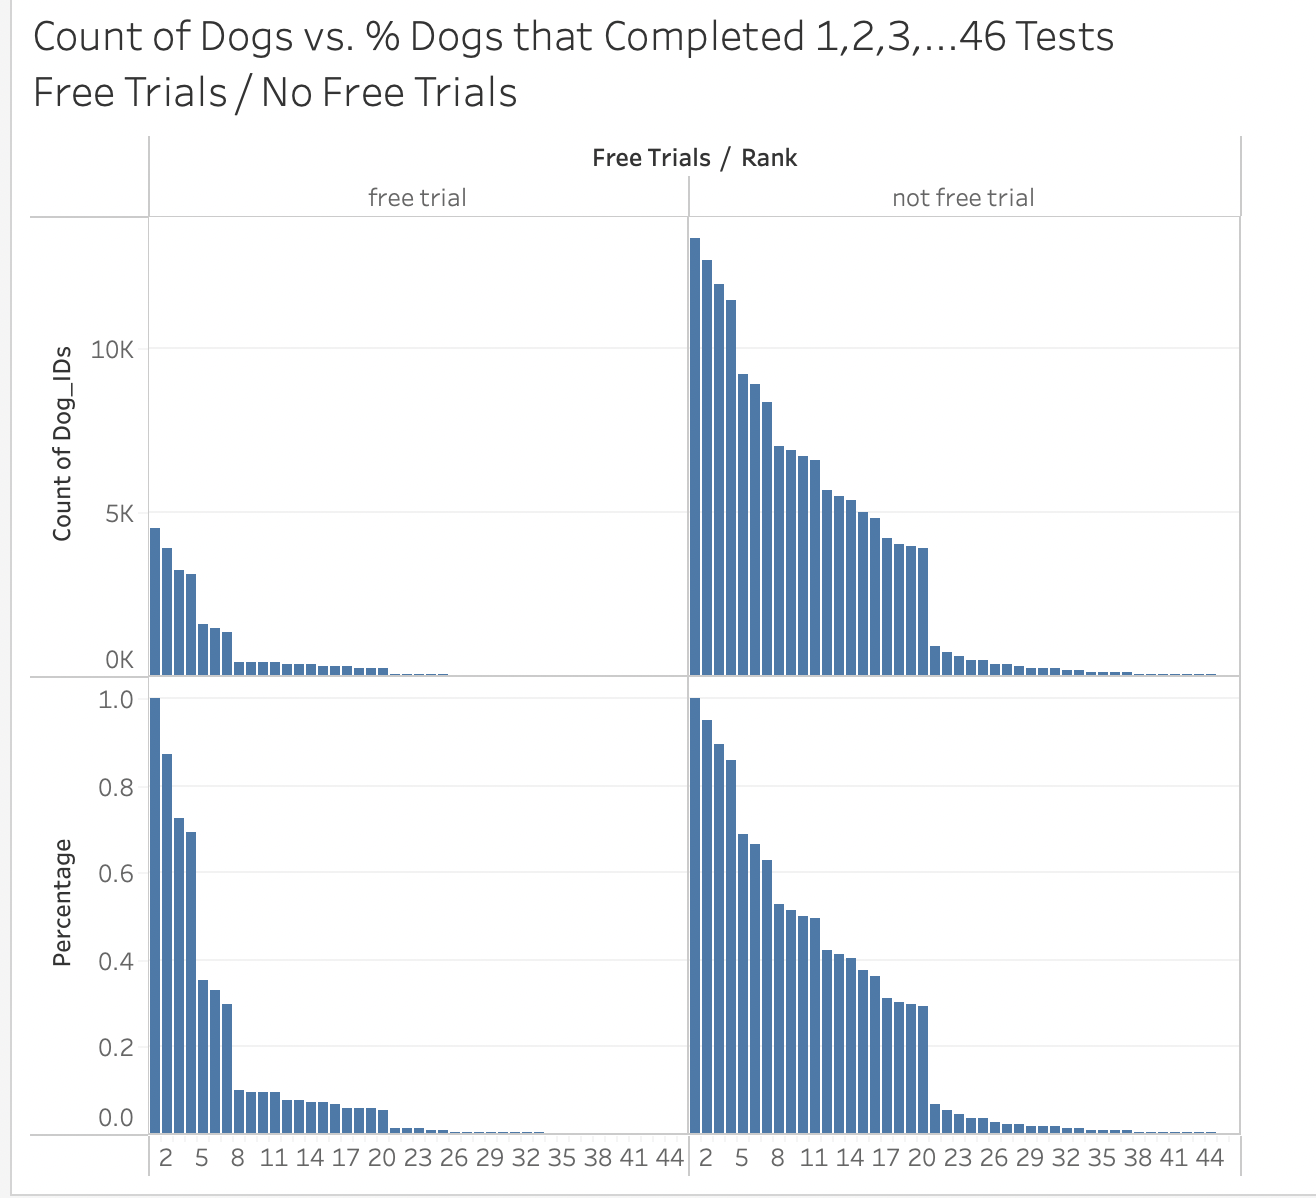

This shows that only 35% of free trial users continued after the 4th (free) test, while 69% of regular users continued after the 4th test. 